In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import scipy.optimize as opt
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar


In [2]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

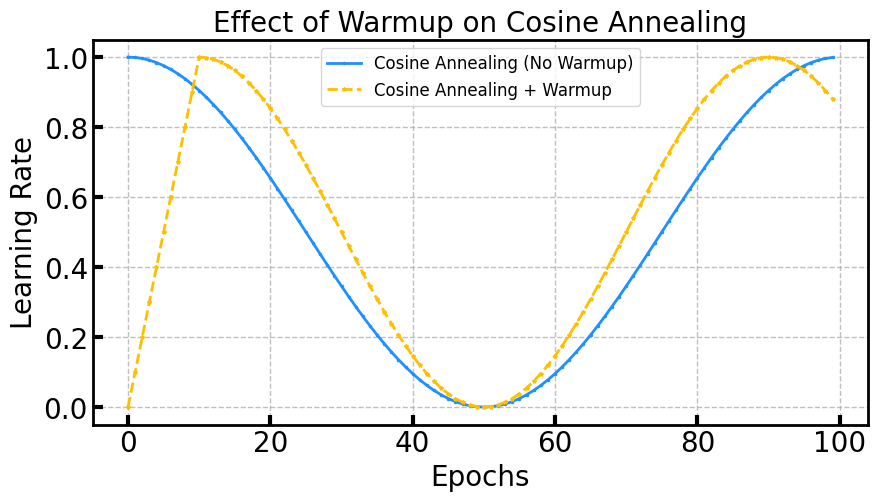

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

def cosine_annealing_with_warmup(epochs, T_warmup, T_0, eta_max=1, eta_min=0):
    """
    Compute the learning rate schedule with cosine annealing and warmup.
    
    Parameters:
        epochs (int): Total epochs.
        T_warmup (int): Warmup duration.
        T_0 (int): Cosine cycle duration after warmup.
        eta_max (float): Maximum learning rate.
        eta_min (float): Minimum learning rate.
    
    Returns:
        (array, array): Epochs and corresponding learning rates.
    """
    lr_values = []

    for epoch in range(epochs):
        if epoch < T_warmup:
            # Linear Warmup Phase
            lr = eta_min + (epoch / T_warmup) * (eta_max - eta_min)
        else:
            # Cosine Decay Phase
            T_cur = epoch - T_warmup
            lr = eta_min + 0.5 * (eta_max - eta_min) * (1 + math.cos(math.pi * T_cur / (T_0 - T_warmup)))

        lr_values.append(lr)

    return np.arange(epochs), lr_values

def plot_cosine_annealing_with_warmup():
    # Plot different learning rate schedules
    epochs = 100
    T_warmup = 10  # Number of epochs for warmup
    T_0 = 50       # Total cycle length

    fig, ax = plt.subplots(figsize=(10, 5))

    # Without Warmup (Standard Cosine Annealing)
    x1, y1 = cosine_annealing_with_warmup(epochs, 0, T_0)
    ax.plot(x1, y1, label="Cosine Annealing (No Warmup)")

    # With Warmup
    x2, y2 = cosine_annealing_with_warmup(epochs, T_warmup, T_0)
    ax.plot(x2, y2, label="Cosine Annealing + Warmup", linestyle="dashed")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Learning Rate")
    ax.set_title("Effect of Warmup on Cosine Annealing")
    ax.legend()
    plt.show()
plot_cosine_annealing_with_warmup()

In [4]:
def compute_sawtooth_approx(n, x, a=1):
    total = np.zeros_like(x)
    bin_coeff_denominator = math.comb(2 * n, n)  # Binomial coefficient in denominator

    for k in range(1, n + 1):
        bin_coeff = math.comb(2 * n, n - k)  # Binomial coefficient in numerator
        term = (bin_coeff / (bin_coeff_denominator * k)) * np.sin(k * x / a)
        total += term

    return total

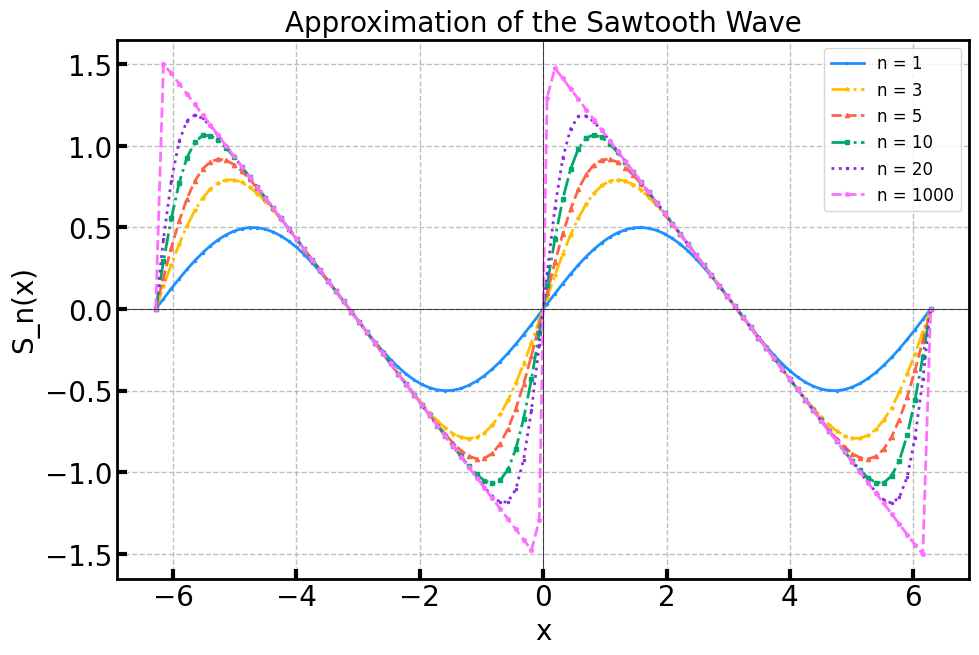

In [5]:
def plot_sawthooth_approx():
    # Plot the function for increasing values of n
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    n_values = [1, 3, 5, 10, 20,1000]

    fig, ax = plt.subplots(figsize=(11, 7))

    for n in n_values:
        y = compute_sawtooth_approx(n, x)
        ax.plot(x, y, label=f"n = {n}")

    ax.set_xlabel("x")
    ax.set_ylabel("S_n(x)")
    ax.set_title("Approximation of the Sawtooth Wave")
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.legend()
    plt.show()
plot_sawthooth_approx()

In [6]:
def asymmetric_sinusoidal_core(n, x, a, shift=0):
    total = np.zeros_like(x, dtype=np.float64)
    bin_coeff_denominator = math.comb(2 * n, n)  # Binomial coefficient in denominator

    for k in range(1, n + 1):
        bin_coeff = math.comb(2 * n, n - k)  # Binomial coefficient in numerator
        term = (bin_coeff / (bin_coeff_denominator * k)) * np.sin(a * k * (x + shift))
        total += term

    return total

In [7]:
def find_peak_x(n, a, shift=0):
    return minimize_scalar(lambda x: -asymmetric_sinusoidal_core(n, x, a, shift=shift), bounds=(0, 10), method='bounded').x

In [8]:
def asymmetric_sinusoidal_unit(n, x, a):
    n_reference = 10
    first_peak_x_ref = find_peak_x(n_reference, a, shift=0)
    
    first_peak_x = find_peak_x(n, a, shift=0)
    x_shifted = x - first_peak_x_ref + first_peak_x  # Keep peak location stable
    wavelength = find_peak_x(n, a, shift=first_peak_x)

    amplitude_norm = asymmetric_sinusoidal_core(n, first_peak_x, a, shift=0)
    return asymmetric_sinusoidal_core(n, x_shifted, wavelength*a, shift=first_peak_x) / amplitude_norm
    

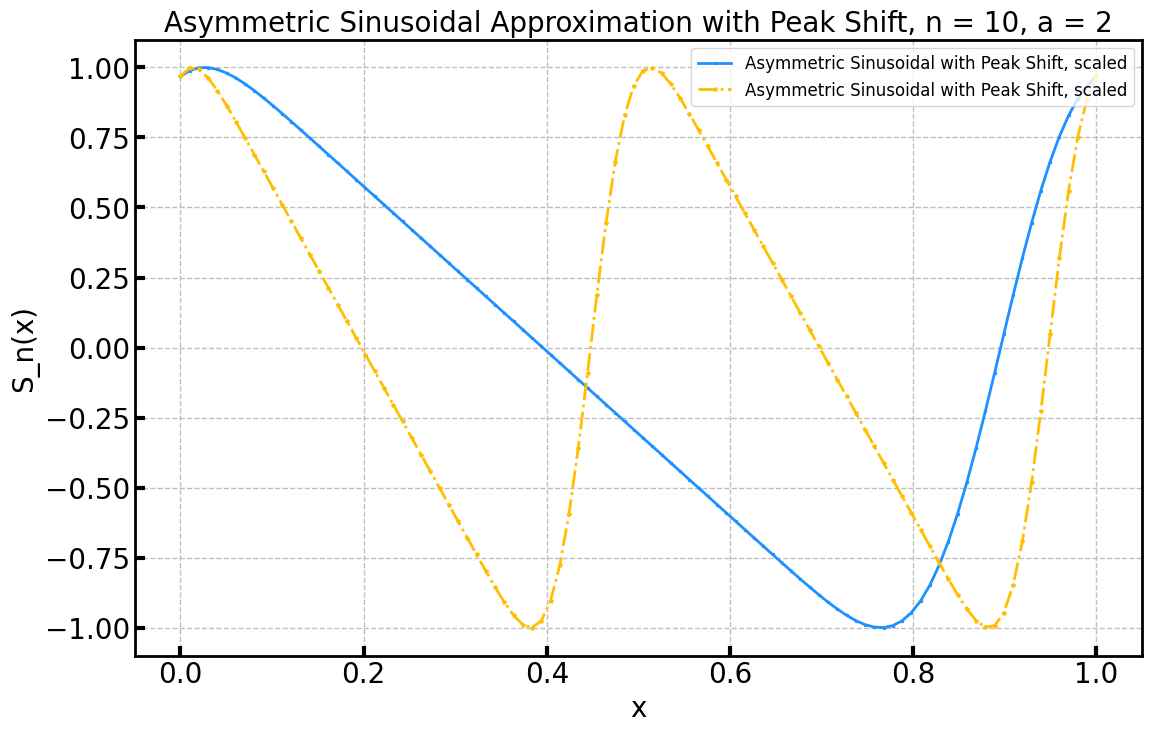

In [9]:
def plot_asymmetric_sinusoidal():
    n = 10
    a_s = [1, 2]
    x = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots(figsize=(13, 8))
    for a in a_s: 
        # y = asymmetric_sinusoidal_core(n, x, a)
        y_adj = asymmetric_sinusoidal_unit(n, x, a)
        ax.plot(x, y_adj, label="Asymmetric Sinusoidal with Peak Shift, scaled")
        # ax.plot(x, y, label="Asymmetric Sinusoidal")
    ax.set_xlabel("x")
    ax.set_ylabel("S_n(x)")
    ax.set_title(f"Asymmetric Sinusoidal Approximation with Peak Shift, n = {n}, a = {a}")
    ax.legend()
plot_asymmetric_sinusoidal()
    

In [10]:
def _get_section_and_x(step, section_length):
    section_index = step // section_length  # Identify section
    x = (step % section_length) / section_length  # Normalize x into [0,1]
    return section_index, x


In [11]:
def _get_section_ceiling(section: int, lr_max: float, lr_min: float, n_sections: int):
    height = lr_max - lr_min
    ceiling = lr_max - height * (section / n_sections)
    return ceiling

def _get_section_floor(section: int, lr_max: float, lr_min: float, n_sections: int):
    """Calculate the floor LR for a given section."""
    return _get_section_ceiling(section + 1, lr_max, lr_min, n_sections)

In [12]:
def _get_section_amplitude_and_height(ceiling, floor):
    amplitude = (ceiling - floor) / 2
    height = ceiling - amplitude
    return amplitude, height

In [13]:
def adapted_asymmetric_sinusoidal(n, x, a, amplitude, height):
    """ Computes the shifted and scaled asymmetric sinusoidal function. """
    y = asymmetric_sinusoidal_unit(n, x, a)
    return height + y * amplitude

In [14]:
def get_value(step, section_length, ceiling, floor, frequency_per_section):
    """ Computes the function value for a given step. """
    section_index, x = _get_section_and_x(step, section_length)
    amplitude, height = _get_section_amplitude_and_height(ceiling, floor)

    # ✅ Instead of modifying frequency, scale `x` to fit `frequency_per_section` oscillations
    x_scaled = x * frequency_per_section  # Expands the input domain

    n = 10
    return adapted_asymmetric_sinusoidal(n, x_scaled, 1, amplitude, height)  # Keep function at frequency 1


In [15]:
def define_synthetic_function(lr_max, lr_min, total_steps, frequency_per_section, n_sections):
    """ Generates the entire synthetic function. """
    section_length = total_steps // n_sections
    values = []
    
    for step in range(total_steps):
        section_index, x = _get_section_and_x(step, section_length)
        ceiling = _get_section_ceiling(section_index, lr_max, lr_min, n_sections)
        floor = _get_section_floor(section_index, lr_max, lr_min, n_sections)
        value = get_value(step, section_length, ceiling, floor, frequency_per_section)
        values.append(value)
    
    return values

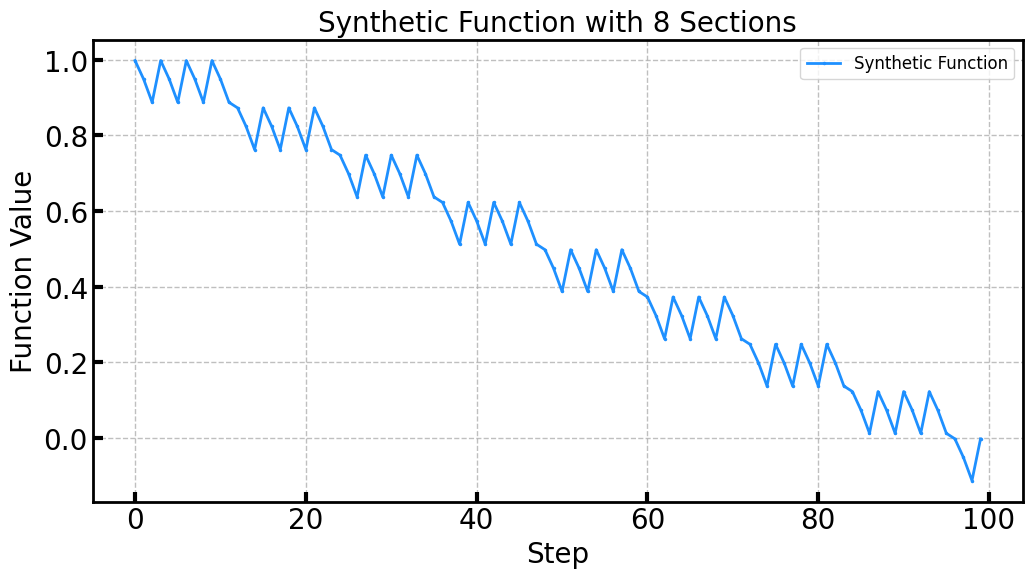

In [16]:
def plot_synthetic_function(frequency_per_section = 1):
    """ Plots the generated synthetic function. """
    lr_max = 1
    lr_min = 0
    total_steps = 100
    x = np.arange(total_steps)  # Correct x-axis representation for steps
    n_sections = 8

    values = define_synthetic_function(lr_max, lr_min, total_steps, frequency_per_section, n_sections)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x, values, label="Synthetic Function", linestyle="-")
    
    ax.set_xlabel("Step")
    ax.set_ylabel("Function Value")
    ax.set_title(f"Synthetic Function with {n_sections} Sections")
    ax.legend()
    plt.show()

plot_synthetic_function(4)